# Transfer Learning

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
df = [] 
for dirname, _, filenames in os.walk('C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df.append([dirname, filename])
df = pd.DataFrame(df,columns=['dirname','filename'])
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/maskdata\maskdata\test\without_mask\325.jpg
C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/maskdata\maskdata\test\without_mask\326.jpg
C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/maskdata\maskdata\test\without_mask\327.jpg
C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/maskdata\maskdata\test\without_mask\328.jpg
C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/maskdata\maskdata\test\without_mask\329.jpg
C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/maskdata\maskdata\test\without_mask\330.jpg
C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/maskdata\maskdata\test\without_mask\331.jpg
C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/maskdata\maskdata\test\without_mask\332.jpg
C:/Users/ytsat/Documents/DataScience/data/covid19_masks_images/maskdata\maskdata\test\without_mask\334.jpg
C:/Users/ytsat/Documents/DataScience/

There are two group of images: 
 
a) mask2.0 which has the mask indicator (0/1).
 
b) maskdata which has the mask indicator as "with_mask"/"without_mask"

In [4]:
df.head()

,dirname,filename
0,C:/Users/ytsat/Documents/DataScience/data/covi...,325.jpg
1,C:/Users/ytsat/Documents/DataScience/data/covi...,326.jpg
2,C:/Users/ytsat/Documents/DataScience/data/covi...,327.jpg
3,C:/Users/ytsat/Documents/DataScience/data/covi...,328.jpg
4,C:/Users/ytsat/Documents/DataScience/data/covi...,329.jpg


In [34]:
### change the backslashes
df['dirname'] =  ['/'.join(c.split('\\')) for c in df['dirname'].astype(str)]

In [35]:
print(df['dirname'][0])

C:/Users/Thomas/Documents/BIDS/ML/covid19_masks_images/maskdata/maskdata/test/without_mask


In [36]:
df['dirname'].str.contains("(/with_mask$|/1$)", regex=True)

0      False
1      False
2      False
3      False
4      False
       ...  
934     True
935     True
936     True
937     True
938     True
Name: dirname, Length: 939, dtype: bool

In [37]:
df['dirname'].str.contains("/1$", regex=True)

0      False
1      False
2      False
3      False
4      False
       ...  
934     True
935     True
936     True
937     True
938     True
Name: dirname, Length: 939, dtype: bool

In [38]:
df['train'] = np.int32(df['dirname'].str.contains('train', regex=False))
df['mask'] = np.int32(df['dirname'].str.contains("(/with_mask$|/1$)", regex=True))

df['path'] = df['dirname'] + '/' + df['filename']
df.head()

,dirname,filename,train,mask,path
0,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...,325.jpg,0,0,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...
1,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...,326.jpg,0,0,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...
2,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...,327.jpg,0,0,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...
3,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...,328.jpg,0,0,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...
4,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...,329.jpg,0,0,C:/Users/Thomas/Documents/BIDS/ML/covid19_mask...


In [39]:
df.describe()

,train,mask
count,939.000000,939.000000
mean,0.753994,0.512247
std,0.430912,0.500116
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [40]:
pd.crosstab(df['train'],df['mask'])

mask,0,1
train,,
0,143,88
1,315,393


In [41]:
### the rows are ordered by the mask use. We will randomly shuffle the rows
from sklearn.utils import shuffle

df = shuffle(df)

In [42]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser

import matplotlib.pyplot as plt

from keras import applications

from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf


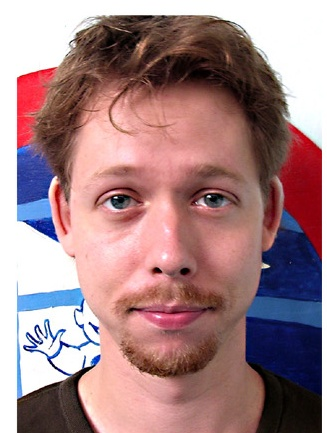

In [43]:
#viewing any image from the train data.
from IPython.display import Image

Image(df['path'][0])


In [44]:
train_data = df[df['train']==1]
test_data = df[df['train']==0]
print(train_data.shape)
print(test_data.shape)

(708, 5)
(231, 5)


In [45]:
train_data.dtypes

dirname     object
filename    object
train        int32
mask         int32
path        object
dtype: object

In [46]:
import cv2     # Library for image processing

X_train = []
y_train = []
image_size = 150     # set the image size to 150 pixels
for i in range(train_data.shape[0]):
    # converting the image to gray scale
    #img_array = cv2.imread(train_data['path'].iloc[i], cv2.IMREAD_GRAYSCALE)
    img_array = cv2.imread(train_data['path'].iloc[i])
    new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array

    # encoding the labels. with_mask = 1 and without_mask = 0
    if train_data['mask'].iloc[i] == 1:
        y_train.append(1)
    else:
        y_train.append(0)
    X_train.append(new_img_array)

In [47]:
X_test = []
y_test = []
image_size = 150      # set the image size to 150 pixels
for i in range(test_data.shape[0]):
    # converting the image to gray scale
    #img_array = cv2.imread(test_data['path'].iloc[i], cv2.IMREAD_GRAYSCALE)
    img_array = cv2.imread(test_data['path'].iloc[i])
    new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array

    # encoding the labels. with_mask = 1 and without_mask = 0
    if test_data['mask'].iloc[i] == 1:
        y_test.append(1)
    else:
        y_test.append(0)
    X_test.append(new_img_array)
    

In [48]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

708
708
231
231


In [49]:
X_train[0]

array([[[ 93, 105, 105],
        [ 94, 107, 107],
        [ 94, 106, 106],
        ...,
        [ 81, 100, 105],
        [ 77,  97, 104],
        [ 77,  96, 103]],

       [[ 91, 103, 103],
        [ 94, 106, 106],
        [ 95, 107, 107],
        ...,
        [ 76,  96, 101],
        [ 77,  96, 103],
        [ 79,  98, 105]],

       [[ 93, 105, 107],
        [ 92, 104, 106],
        [ 91, 103, 105],
        ...,
        [ 75,  95, 100],
        [ 75,  94, 101],
        [ 76,  95, 102]],

       ...,

       [[ 12,  18,  23],
        [ 14,  20,  26],
        [ 12,  18,  24],
        ...,
        [ 49,  44, 112],
        [ 51,  46, 114],
        [ 45,  40, 108]],

       [[ 16,  23,  26],
        [ 13,  22,  25],
        [ 12,  21,  25],
        ...,
        [ 46,  40, 111],
        [ 51,  45, 116],
        [ 46,  40, 111]],

       [[ 31,  38,  41],
        [ 16,  25,  29],
        [ 12,  21,  25],
        ...,
        [ 48,  41, 113],
        [ 47,  41, 113],
        [ 43,  36, 108]]

In [50]:
y_train[0]

0

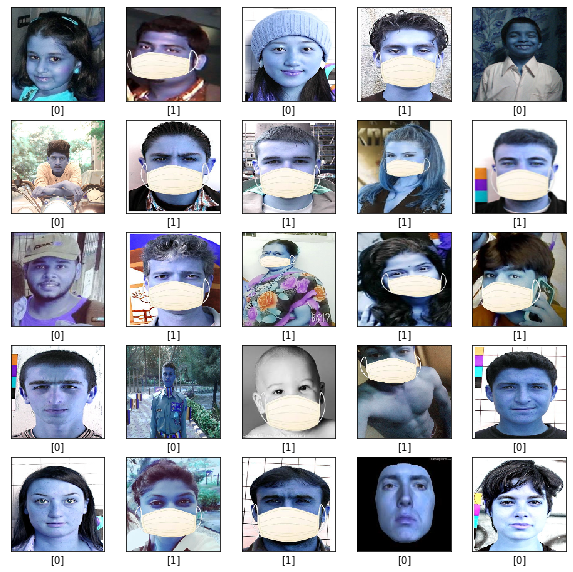

In [51]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel([y_train[i]])


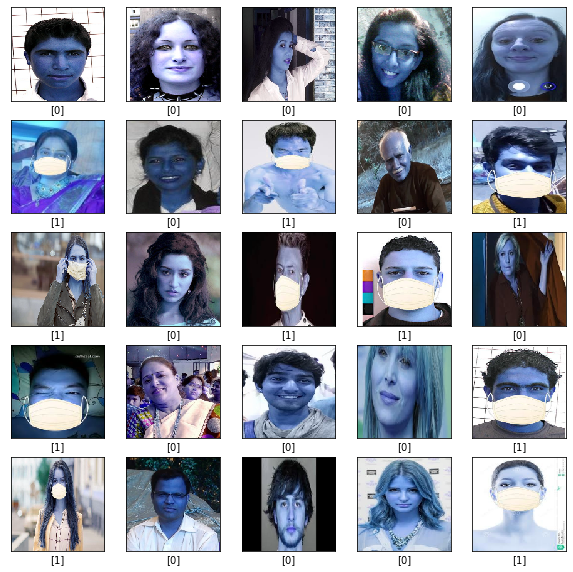

In [52]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel([y_test[i]])


In [53]:
X_train = [x / 255. for x in X_train]
X_test = [x / 255. for x in X_test]

In [54]:
X_train[0]

array([[[0.36470588, 0.41176471, 0.41176471],
        [0.36862745, 0.41960784, 0.41960784],
        [0.36862745, 0.41568627, 0.41568627],
        ...,
        [0.31764706, 0.39215686, 0.41176471],
        [0.30196078, 0.38039216, 0.40784314],
        [0.30196078, 0.37647059, 0.40392157]],

       [[0.35686275, 0.40392157, 0.40392157],
        [0.36862745, 0.41568627, 0.41568627],
        [0.37254902, 0.41960784, 0.41960784],
        ...,
        [0.29803922, 0.37647059, 0.39607843],
        [0.30196078, 0.37647059, 0.40392157],
        [0.30980392, 0.38431373, 0.41176471]],

       [[0.36470588, 0.41176471, 0.41960784],
        [0.36078431, 0.40784314, 0.41568627],
        [0.35686275, 0.40392157, 0.41176471],
        ...,
        [0.29411765, 0.37254902, 0.39215686],
        [0.29411765, 0.36862745, 0.39607843],
        [0.29803922, 0.37254902, 0.4       ]],

       ...,

       [[0.04705882, 0.07058824, 0.09019608],
        [0.05490196, 0.07843137, 0.10196078],
        [0.04705882, 0

In [55]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [56]:
print(X_train.shape)
print(X_test.shape)

(708, 150, 150, 3)
(231, 150, 150, 3)


In [57]:
y_train = np.array(y_train)
y_test = np.array(y_test)
print(y_train.shape)
print(y_test.shape)


(708,)
(231,)


In [58]:
## data preprocessing
X_train = X_train.reshape(708, 150, 150, 3)
X_test = X_test.reshape(231, 150, 150, 3)

In [59]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150,150,3),padding='valid',activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.3))


model.add(Flatten())
          
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [60]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

In [62]:
res = model.fit(X_train, y_train,
          batch_size=1000, epochs=20,
          verbose=2,
          validation_data=(X_test, y_test)
        )

Epoch 1/20
1/1 - 2s - loss: 6.6171e-08 - accuracy: 0.4520 - val_loss: 4.5413e-08 - val_accuracy: 0.6190
Epoch 2/20
1/1 - 1s - loss: 6.6171e-08 - accuracy: 0.4534 - val_loss: 4.5413e-08 - val_accuracy: 0.6190
Epoch 3/20
1/1 - 1s - loss: 6.6171e-08 - accuracy: 0.4435 - val_loss: 4.5413e-08 - val_accuracy: 0.6190
Epoch 4/20
1/1 - 1s - loss: 6.6171e-08 - accuracy: 0.4506 - val_loss: 4.5413e-08 - val_accuracy: 0.6190
Epoch 5/20
1/1 - 1s - loss: 6.6171e-08 - accuracy: 0.4435 - val_loss: 4.5413e-08 - val_accuracy: 0.6190
Epoch 6/20
1/1 - 1s - loss: 6.6171e-08 - accuracy: 0.4393 - val_loss: 4.5413e-08 - val_accuracy: 0.6190
Epoch 7/20
1/1 - 1s - loss: 6.6171e-08 - accuracy: 0.4492 - val_loss: 4.5413e-08 - val_accuracy: 0.6190
Epoch 8/20
1/1 - 1s - loss: 6.6171e-08 - accuracy: 0.4463 - val_loss: 4.5413e-08 - val_accuracy: 0.6190
Epoch 9/20
1/1 - 1s - loss: 6.6171e-08 - accuracy: 0.4477 - val_loss: 4.5413e-08 - val_accuracy: 0.6190
Epoch 10/20
1/1 - 1s - loss: 6.6171e-08 - accuracy: 0.4492 - val

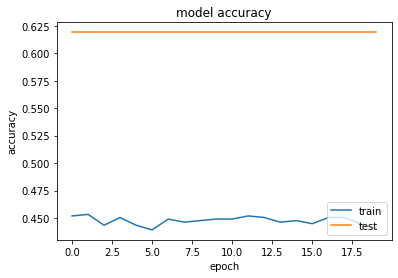

In [63]:
# plotting the metrics: Accuracy
plt.plot(res.history['accuracy'])
plt.plot(res.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

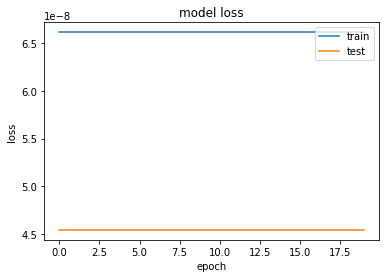

In [64]:
# plotting the metrics: loss
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [65]:
# calculate predictions
predict_classes = model.predict_classes(X_test)
predict_classes[0:30]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [66]:
y_test[0:30]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0])

In [67]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 109ms/step - loss: 4.5413e-08 - accuracy: 0.6190


[4.5413063531896114e-08, 0.6190476417541504]

## Transfer Learning with ResNet50

In [68]:
base_model = applications.Xception(
    weights='imagenet',            # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),     # minimum expected shape for Xception is 150 pixels
    include_top=False)             # Do not include the ImageNet classifier at the top.

83689472/83683744 [==============================] - 8s 0us/step


In [69]:
base_model.trainable = False

In [70]:
from keras import applications

from keras.models import Sequential, Model, load_model#, base_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import Input
import tensorflow as tf


In [71]:
inputs = Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

In [72]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [73]:
#model = tf.keras.Sequential([
#    tf.keras.layers.Flatten(input_shape=(64, 64)),    # flattening the image
#    tf.keras.layers.Dense(200, activation='relu'),
#    tf.keras.layers.Dense(100, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['BinaryAccuracy'])


In [74]:
res = model.fit(X_train, y_train, epochs=20, batch_size = 30, validation_data=(X_test, y_test))
#res = model.fit(X_train, y_train, epochs=20, batch_size = 30)

Epoch 1/20
24/24 [==============================] - 35s 1s/step - loss: 0.3330 - binary_accuracy: 0.9124 - val_loss: 0.4108 - val_binary_accuracy: 0.9481
Epoch 2/20
24/24 [==============================] - 41s 2s/step - loss: 0.2120 - binary_accuracy: 0.9746 - val_loss: 0.3658 - val_binary_accuracy: 0.9394
Epoch 3/20
24/24 [==============================] - 41s 2s/step - loss: 0.0222 - binary_accuracy: 0.9873 - val_loss: 0.2551 - val_binary_accuracy: 0.9610
Epoch 4/20
24/24 [==============================] - 39s 2s/step - loss: 0.0122 - binary_accuracy: 0.9901 - val_loss: 0.2452 - val_binary_accuracy: 0.9740
Epoch 5/20
24/24 [==============================] - 37s 2s/step - loss: 0.0073 - binary_accuracy: 1.0000 - val_loss: 0.2409 - val_binary_accuracy: 0.9740
Epoch 6/20
24/24 [==============================] - 38s 2s/step - loss: 0.0074 - binary_accuracy: 0.9972 - val_loss: 0.2390 - val_binary_accuracy: 0.9697
Epoch 7/20
24/24 [==============================] - 38s 2s/step - loss: 0.00

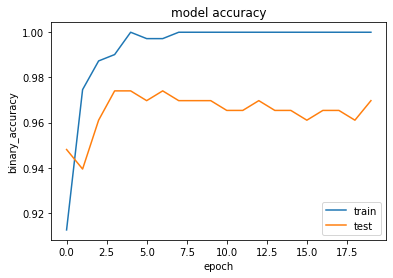

In [75]:
# plotting the metrics: Accuracy
plt.plot(res.history['binary_accuracy'])
plt.plot(res.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

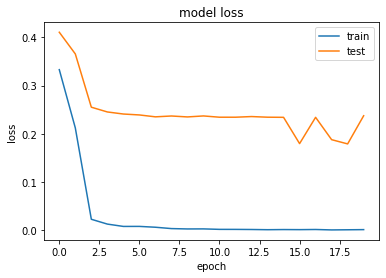

In [76]:
# plotting the metrics: loss
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')


### VGG19 Model

In [123]:
base_model = applications.VGG19(
    weights='imagenet',            # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),     # minimum expected shape for VGG19 is 150 pixels
    include_top=False)             # Do not include the ImageNet classifier at the top.

In [78]:
base_model.trainable = False


inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])


In [79]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [80]:

res = model.fit(X_train, y_train, epochs=10, batch_size = 20, validation_data=(X_test, y_test))


Epoch 1/10
36/36 [==============================] - 91s 3s/step - loss: 1.6658 - binary_accuracy: 0.5989 - val_loss: 0.5790 - val_binary_accuracy: 0.6797
Epoch 2/10
36/36 [==============================] - 100s 3s/step - loss: 0.4585 - binary_accuracy: 0.8220 - val_loss: 0.4940 - val_binary_accuracy: 0.7619
Epoch 3/10
36/36 [==============================] - 99s 3s/step - loss: 0.3236 - binary_accuracy: 0.9138 - val_loss: 0.3554 - val_binary_accuracy: 0.8528
Epoch 4/10
36/36 [==============================] - 100s 3s/step - loss: 0.2232 - binary_accuracy: 0.9463 - val_loss: 0.3251 - val_binary_accuracy: 0.8658
Epoch 5/10
36/36 [==============================] - 99s 3s/step - loss: 0.1697 - binary_accuracy: 0.9605 - val_loss: 0.3093 - val_binary_accuracy: 0.9177
Epoch 6/10
36/36 [==============================] - 98s 3s/step - loss: 0.1375 - binary_accuracy: 0.9605 - val_loss: 0.2689 - val_binary_accuracy: 0.9091
Epoch 7/10
36/36 [==============================] - 99s 3s/step - loss: 0.

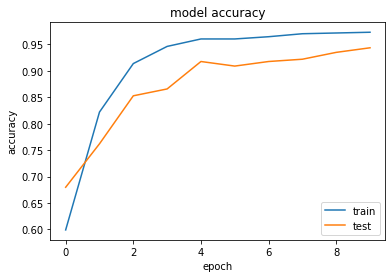

In [81]:

# plotting the metrics: Accuracy
plt.plot(res.history['binary_accuracy'])
plt.plot(res.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

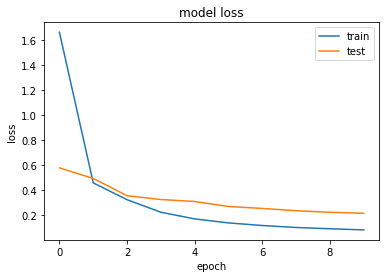

In [82]:
# plotting the metrics: loss
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')


In [83]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 17s 2s/step - loss: 0.2148 - binary_accuracy: 0.9437


[0.21480122208595276, 0.9437229633331299]

In [84]:
#get the predictions for the test data
predicted_classes = model.predict(X_test)

In [85]:
yhat_test = predicted_classes.copy()
yhat_test = yhat_test.flatten()
yhat_test[yhat_test>=0.05] = 1
yhat_test[yhat_test<0.05] = 0

In [86]:
correct = np.nonzero(y_test==yhat_test)[0]
incorrect = np.nonzero(y_test!=yhat_test)[0]

In [87]:
np.nonzero(y_test==yhat_test)[0]

array([  0,   5,   7,   9,  10,  11,  12,  13,  15,  17,  19,  20,  21,
        24,  25,  26,  27,  28,  29,  30,  31,  33,  35,  37,  38,  39,
        40,  42,  43,  45,  46,  47,  49,  51,  52,  53,  54,  55,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  68,  69,  70,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  82,  83,  84,  85,  86,
        88,  90,  91,  93,  94,  95,  96,  97,  98,  99, 102, 103, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135,
       136, 137, 139, 140, 144, 145, 146, 149, 150, 151, 152, 153, 155,
       156, 157, 159, 160, 161, 164, 165, 167, 168, 169, 170, 171, 172,
       173, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 189,
       191, 192, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       207, 208, 210, 211, 212, 213, 214, 215, 217, 218, 219, 220, 222,
       223, 224, 226, 227, 228, 229, 230], dtype=int64)

In [88]:
np.nonzero(y_test!=yhat_test)[0]

array([  1,   2,   3,   4,   6,   8,  14,  16,  18,  22,  23,  32,  34,
        36,  41,  44,  48,  50,  56,  67,  71,  81,  87,  89,  92, 100,
       101, 104, 115, 118, 119, 134, 138, 141, 142, 143, 147, 148, 154,
       158, 162, 163, 166, 174, 182, 187, 188, 190, 193, 196, 206, 209,
       216, 221, 225], dtype=int64)

In [89]:
print(len(correct))
print(len(incorrect))
print(np.int32(yhat_test))
print(np.int32(y_test))


176
55
[0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1
 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0
 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0
 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1
 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1
 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1
 1 0 1 1 1 1 0 1 1]
[0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0
 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0
 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0
 1 0 1 0 1 1 0 1 1]


In [90]:
correct

array([  0,   5,   7,   9,  10,  11,  12,  13,  15,  17,  19,  20,  21,
        24,  25,  26,  27,  28,  29,  30,  31,  33,  35,  37,  38,  39,
        40,  42,  43,  45,  46,  47,  49,  51,  52,  53,  54,  55,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  68,  69,  70,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  82,  83,  84,  85,  86,
        88,  90,  91,  93,  94,  95,  96,  97,  98,  99, 102, 103, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135,
       136, 137, 139, 140, 144, 145, 146, 149, 150, 151, 152, 153, 155,
       156, 157, 159, 160, 161, 164, 165, 167, 168, 169, 170, 171, 172,
       173, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 189,
       191, 192, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       207, 208, 210, 211, 212, 213, 214, 215, 217, 218, 219, 220, 222,
       223, 224, 226, 227, 228, 229, 230], dtype=int64)

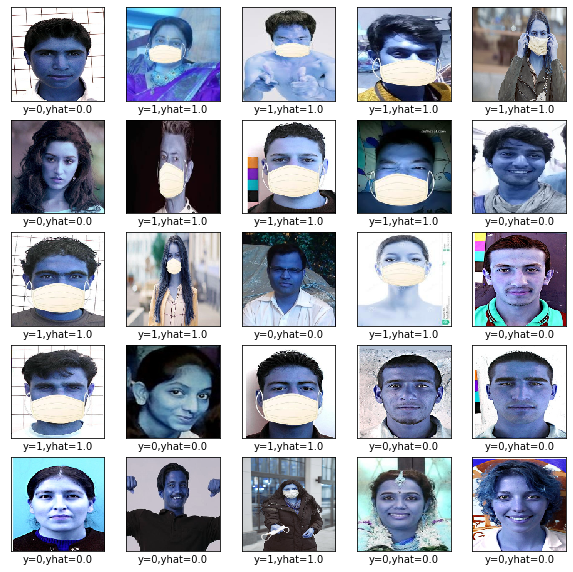

In [91]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[correct[i]], cmap=plt.cm.binary)
    plt.xlabel("y={},yhat={}".format(y_test[correct[i]],yhat_test[correct[i]]))

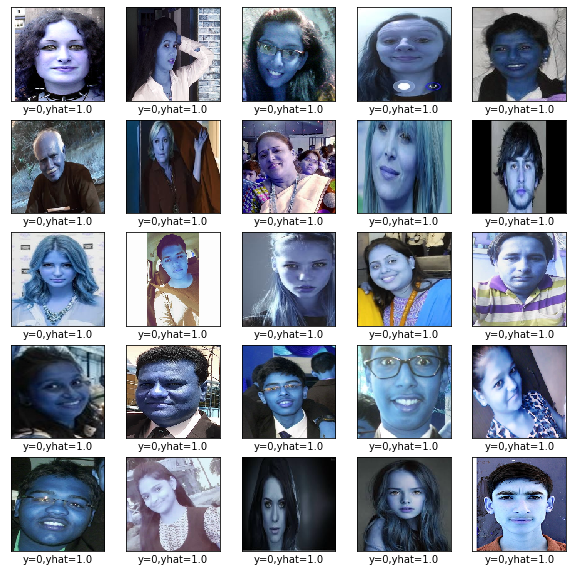

In [92]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[incorrect[i]], cmap=plt.cm.binary)
    plt.xlabel("y={},yhat={}".format(y_test[incorrect[i]],yhat_test[incorrect[i]]))

In [93]:
np.int32(y_test==yhat_test)

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [94]:
## accuracy
sum(np.int32(y_test==yhat_test))/len(y_test)

0.7619047619047619

In [95]:
y_test

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1])

In [96]:
yhat_test

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 1.

### Saving and Loading models

In [237]:
from keras.models import save_model, load_model

In [243]:
model.save('mask_model.h5')

In [244]:
model = load_model('mask_model.h5')

# Model Embeddings

In [233]:
base_model = applications.VGG19(
    weights='imagenet',            # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),     # minimum expected shape for VGG19 is 150 pixels
    include_top=False)             # Do not include the ImageNet classifier at the top.

In [192]:
base_model.trainable = False


inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

#### here we add a dense layer of 500 nodes as the last layer. Those will be our features for the extraction!
outputs = Dense(500)(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])


In [193]:
model.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_20  (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               256500    
Total params: 20,280,884
Trainable params: 256,500
Non-trainable params: 20,024,384
_________________________________________________________________


In [194]:
output_array = model.predict(X_train)
print(output_array.shape)

(708, 500)


In [195]:
output_array[0]

array([-0.17469299, -0.21532938,  0.44509688, -0.05450005, -0.38041455,
        0.09339049,  0.0168834 ,  0.8710675 , -0.73280823, -0.450055  ,
        0.5449871 , -0.28279576,  0.20580675,  0.6843358 , -0.2517006 ,
       -1.347502  ,  0.47722185,  0.5094749 , -0.33908474, -0.28943482,
       -0.3532705 ,  0.7434878 ,  0.4490709 , -0.0525201 , -0.4662959 ,
        0.00989734,  0.8931809 , -0.523046  ,  0.05915851,  0.03417024,
        0.24951994, -0.01402498,  0.21592239, -0.0716956 , -0.2421998 ,
       -0.446826  ,  0.9836918 ,  0.08097016,  0.73222905,  0.5088139 ,
        1.0100073 , -0.37047887,  0.3163718 ,  0.19595326, -0.6275208 ,
       -0.4619255 , -0.879751  ,  0.39294323,  0.12924401, -0.3001793 ,
       -0.0948815 , -0.78456235,  0.47144708, -0.35703576,  0.18224901,
        0.23800655,  0.54405415,  0.29122674,  0.06815058, -0.02099831,
       -0.6698388 , -0.33230013, -0.74820966, -0.5151013 , -0.61036706,
        0.31914282, -0.42254537, -1.0750697 ,  0.18614408, -0.39

In [232]:
n = X_train2.shape[1]
col_names = ['{}{}'.format(x, y) for y in range(1, n+1) for x in 'V']
print(col_names)
print(len(col_names))

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V1

In [214]:
X_train2 = pd.DataFrame(output_array,columns=col_names)
X_train2.shape

(708, 500)

In [215]:
from sklearn.linear_model import LogisticRegression

In [218]:
model2 = LogisticRegression(max_iter=10000)


model2.fit(X_train2,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [219]:
output_array = model.predict(X_test)
print(output_array.shape)

(231, 500)


In [220]:
X_test2 = pd.DataFrame(output_array,columns=col_names)
X_test2.shape

(231, 500)

In [221]:
pred_train = model2.predict(X_train2)
pred_test = model2.predict(X_test2)

In [222]:
pd.crosstab(pred_train, y_train)

col_0,0,1
row_0,,
0,315,0
1,0,393


In [223]:
pd.crosstab(pred_test, y_test)

col_0,0,1
row_0,,
0,143,6
1,0,82


In [229]:
from sklearn.metrics import classification_report

print("Train Metrics")
print(classification_report(pred_train, y_train))

print("-------------------------------------------------")

print("Test Metrics")
print(classification_report(pred_test, y_test))

Train Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       315
           1       1.00      1.00      1.00       393

    accuracy                           1.00       708
   macro avg       1.00      1.00      1.00       708
weighted avg       1.00      1.00      1.00       708

-------------------------------------------------
Test Metrics
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       149
           1       0.93      1.00      0.96        82

    accuracy                           0.97       231
   macro avg       0.97      0.98      0.97       231
weighted avg       0.98      0.97      0.97       231

